In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"izmuhammadra","key":"ecca26ff376aa5ddee94b7ef560ef8d6"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d chandrimad31/eurusd-forex-trading-daily-data-20032021
!unzip eurusd-forex-trading-daily-data-20032021.zip

100% 111k/111k [00:00<00:00, 391kB/s]
100% 111k/111k [00:00<00:00, 390kB/s]
Archive:  eurusd-forex-trading-daily-data-20032021.zip
  inflating: EURUSD_Candlestick_1_D_ASK_05.05.2003-30.06.2021.csv  


In [ ]:
data = pd.read_csv('EURUSD_Candlestick_1_D_ASK_05.05.2003-30.06.2021.csv', na_values='ND')

In [ ]:
data.shape

(6632, 6)

In [ ]:
data.head()

,Local time,open,high,low,close,volume
0,05.05.2003 00:00:00.000 GMT+0300,1.12354,1.13019,1.12030,1.12804,1053162.797
1,06.05.2003 00:00:00.000 GMT+0300,1.12798,1.14510,1.12738,1.14368,1061122.699
2,07.05.2003 00:00:00.000 GMT+0300,1.14367,1.14448,1.13275,1.13677,1056796.590
3,08.05.2003 00:00:00.000 GMT+0300,1.13675,1.15092,1.13026,1.15026,1058908.699
4,09.05.2003 00:00:00.000 GMT+0300,1.15002,1.15376,1.14362,1.14907,1063989.000


In [ ]:
data.describe()

,open,high,low,close,volume
count,6632.000000,6632.000000,6632.000000,6632.000000,6.632000e+03
mean,1.255694,1.259513,1.251757,1.255722,3.606748e+05
std,0.120032,0.120612,0.119389,0.120012,4.437180e+05
min,1.038960,1.041820,1.034050,1.038980,0.000000e+00
25%,1.149798,1.153650,1.146220,1.149987,0.000000e+00
50%,1.247000,1.251410,1.243175,1.246850,1.950523e+05
75%,1.340720,1.344213,1.337067,1.340710,4.996229e+05
max,1.599500,1.604030,1.593780,1.599120,2.230654e+06


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6632 entries, 0 to 6631
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Local time  6632 non-null   object 
 1   open        6632 non-null   float64
 2   high        6632 non-null   float64
 3   low         6632 non-null   float64
 4   close       6632 non-null   float64
 5   volume      6632 non-null   float64
dtypes: float64(5), object(1)
memory usage: 311.0+ KB


In [ ]:
data_prices = data.drop(['Local time', 'volume'], axis=1)

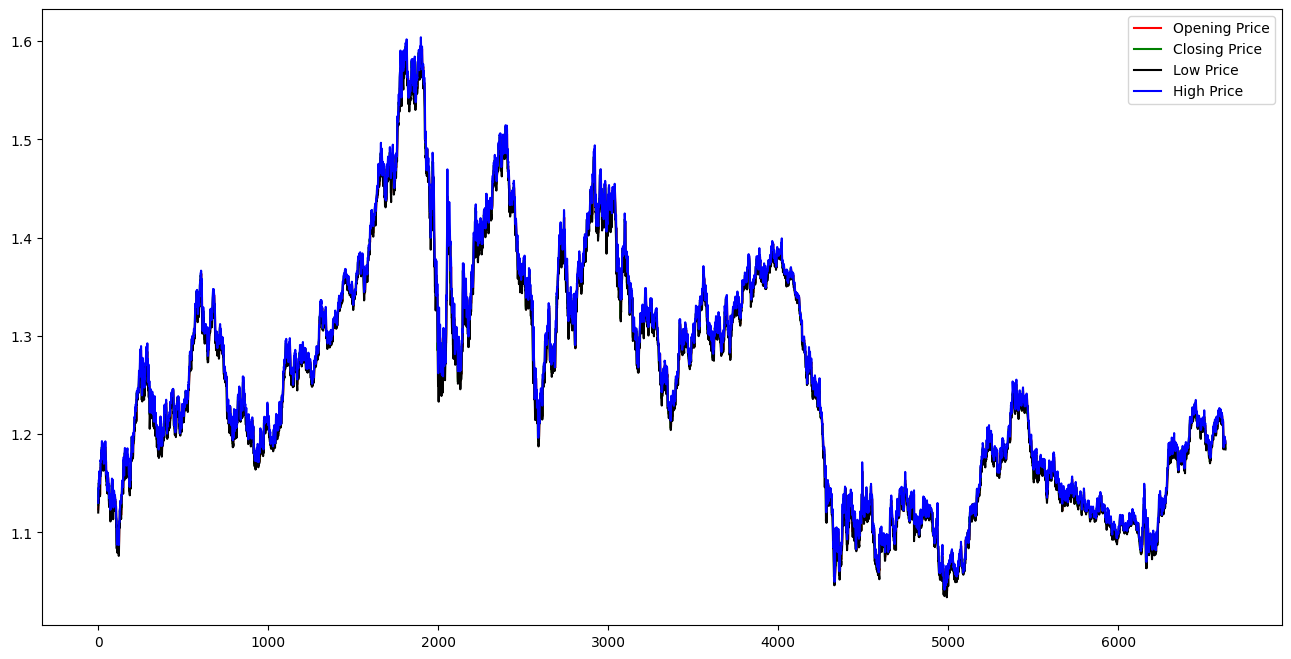

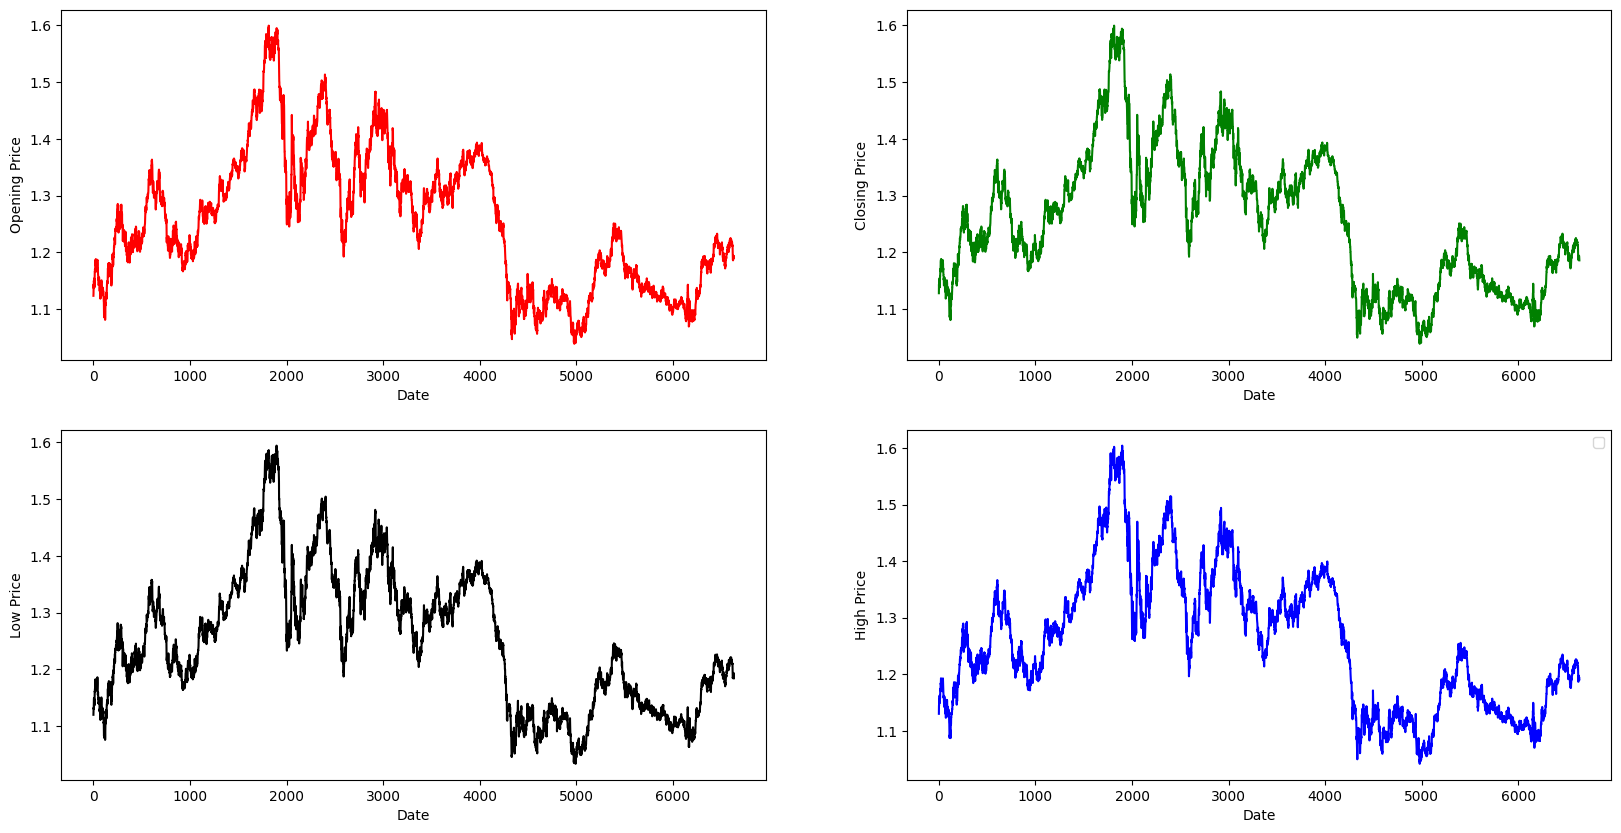

In [ ]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(data_prices['open'], color='red', label = 'Opening Price')
plt.plot(data_prices['close'], color='green', label = 'Closing Price')
plt.plot(data_prices['low'], color='black', label = 'Low Price')
plt.plot(data_prices['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(data_prices['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(data_prices['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(data_prices['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(data_prices['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

In [ ]:
data_prices = data_prices.drop(['close', 'low', 'high'], axis=1)

In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = sc.fit_transform(data_prices)

In [ ]:
data_prices_scaled.shape

(6632, 1)

In [ ]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])

    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,validation_split_percentage = 0)

In [ ]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(5286, 25, 1)
(1321, 25, 1)
(5286, 1)
(1321, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


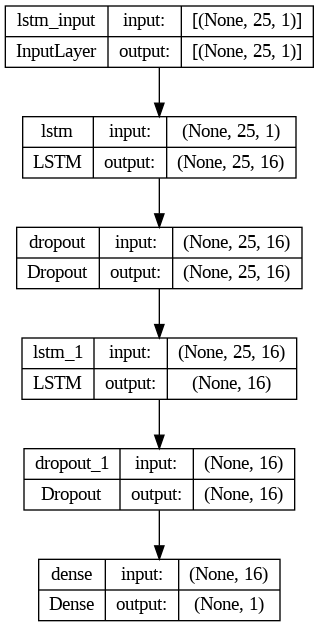

In [ ]:
from tensorflow.keras.utils import plot_model

regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()
plot_model(regressor, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
58/58 [==============================] - 9s 70ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 2/40
58/58 [==============================] - 2s 30ms/step - loss: 0.0100 - root_mean_squared_error: 0.0998 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 3/40
58/58 [==============================] - 2s 33ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 4/40
58/58 [==============================] - 2s 33ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 5/40
58/58 [==============================] - 2s 34ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 6/40
58/58 [==============================] - 2s 30ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0014 - val_root_m

In [ ]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

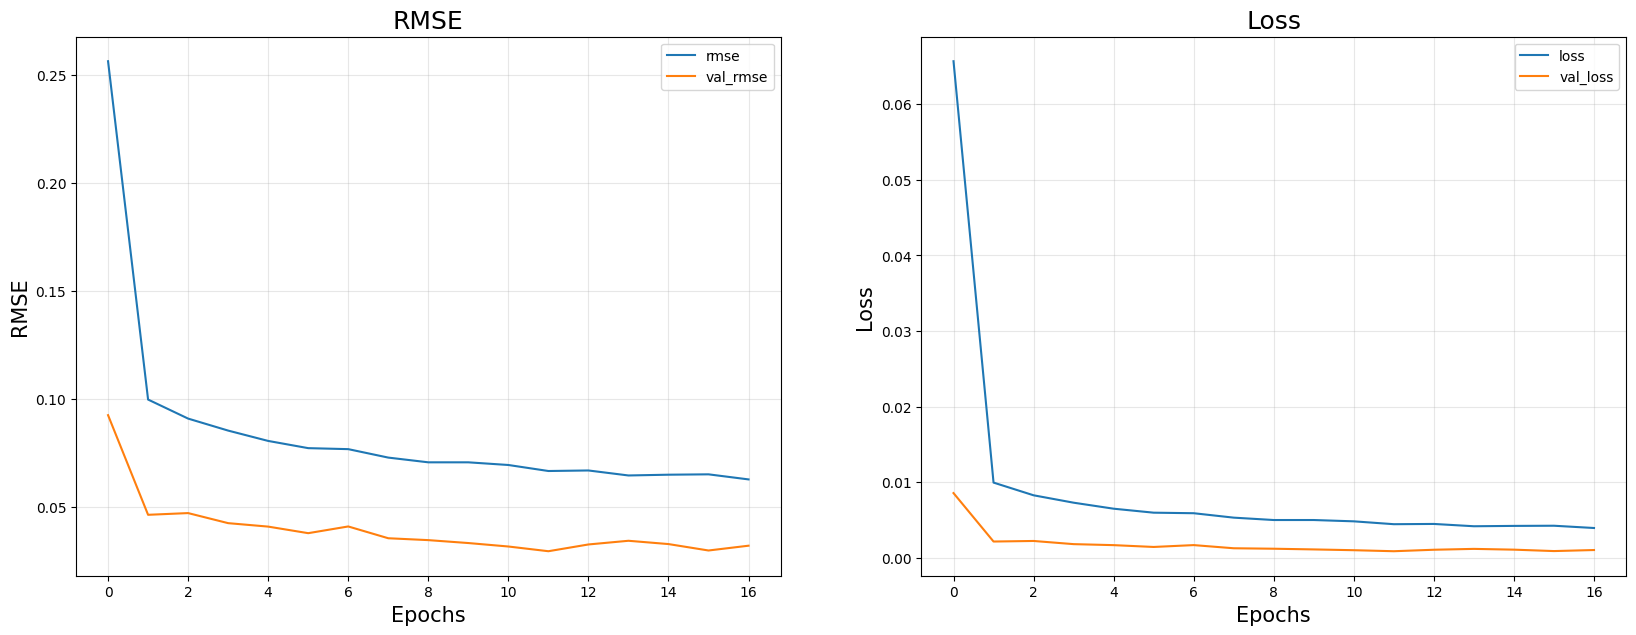

In [ ]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

42/42 [==============================] - 0s 7ms/step - loss: 5.6565e-04 - root_mean_squared_error: 0.0238
test loss, test acc: [0.0006 0.0238]


In [ ]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))

    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist

In [ ]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00181, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00181 to 0.00102, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00102 to 0.00086, saving model to best_model.h5

Epoch 4: val_loss improved from 0.00086 to 0.00082, saving model to best_model.h5

Epoch 5: val_loss improved from 0.00082 to 0.00060, saving model to best_model.h5

Epoch 6: val_loss improved from 0.00060 to 0.00051, saving model to best_model.h5

Epoch 7: val_loss improved from 0.00051 to 0.00033, saving model to best_model.h5

Epoch 8: val_loss did not improve from 0.00033

Epoch 9: val_loss improved from 0.00033 to 0.00031, saving model to b

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
3,False,False,False,32,8,0.2,"[0.00021532726532313973, 0.014674033969640732]","[0.000143449375173077, 0.01197703555226326]"
5,False,False,False,32,32,0.2,"[0.0004680324927903712, 0.02163405902683735]","[0.00024203395878430456, 0.015557440929114819]"
4,False,False,False,32,16,0.2,"[0.0004129874287173152, 0.02032209187746048]","[0.0003004828467965126, 0.01733444072306156]"
2,False,False,False,16,32,0.2,"[0.0005495822406373918, 0.02344316989183426]","[0.0004100525111425668, 0.020249754190444946]"
0,False,False,False,16,8,0.2,"[0.0005713083082810044, 0.023902056738734245]","[0.0006606991519220173, 0.025704069063067436]"
1,False,False,False,16,16,0.2,"[0.0009869902860373259, 0.0314164012670517]","[0.0008373709279112518, 0.028937362134456635]"


In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 8
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0238

Results After Tunning:
 Test Set RMSE: 0.012

50.0% Improvement


In [ ]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 1: val_loss improved from inf to 0.00069, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00069 to 0.00043, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00043 to 0.00040, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00040

Epoch 5: val_loss did not improve from 0.00040

Epoch 6: val_loss improved from 0.00040 to 0.00029, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00029

Epoch 8: val_loss improved from 0.00029 to 0.00026, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.00026

Epoch 10: val_loss did not improve from 0.00026

Epoch 11: val_loss did not improve from 0.00026

Epoch 12: val_loss improved from 0.00026 to 0.00021, saving model to best_model.h5

Epoch 13: val_loss did not improve from 0.00021

Epoch 14: val_loss did not improve from 0.00021

Epoch 15: val_loss did not improve from 0.00021

Epoch 16: val_loss improved from 0.00021 to 0.00016, saving model t

In [ ]:
regressor.evaluate(X_test, y_test)

42/42 [==============================] - 0s 9ms/step - loss: 1.4527e-04


0.00014526584709528834

In [ ]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = regressor.predict(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(y_test.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(y_test.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(y_test.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.987655
R2 Score: 0.987655
Max Error: 0.067496


42/42 [==============================] - 1s 8ms/step


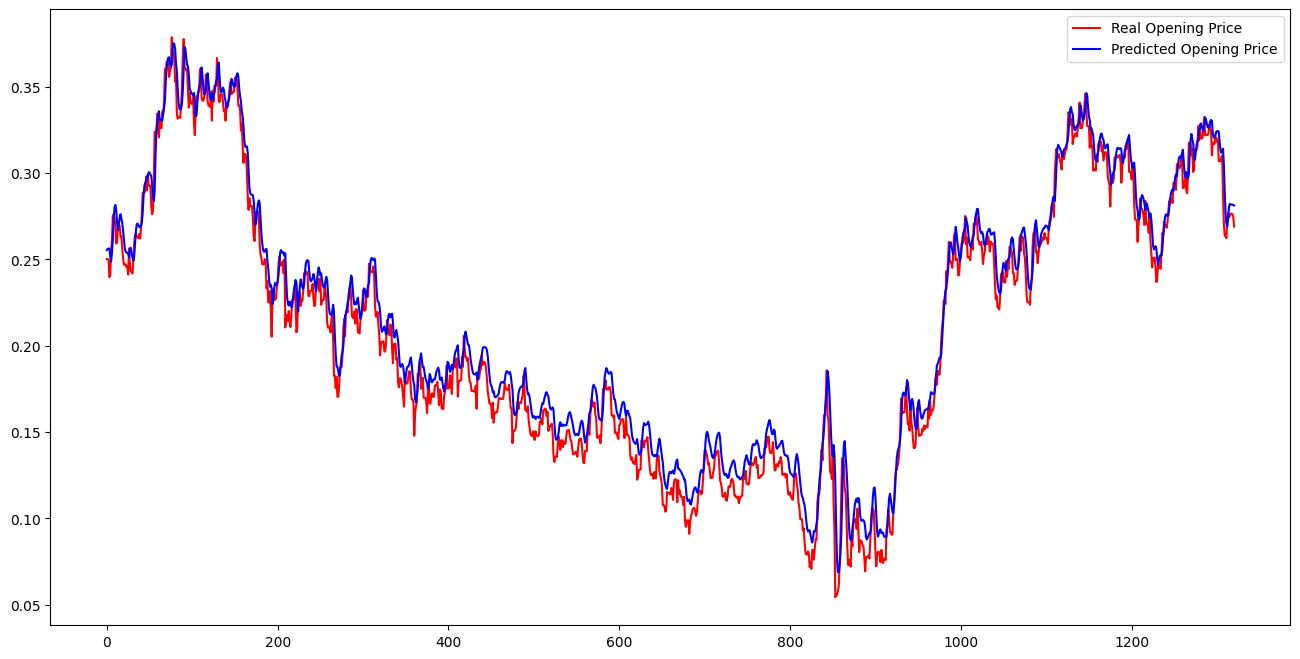

In [ ]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Opening Price')
plt.plot(y_pred, color='blue', label = 'Predicted Opening Price')
plt.legend(loc='best')